In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import scipy.stats as stats
from scipy.stats import f_oneway, kruskal
import statsmodels.formula.api as smf
from scipy.stats import ttest_1samp

warnings.simplefilter(action='ignore', category=FutureWarning)

file_url = 'https://raw.githubusercontent.com/YufanPeter/EPL_Analysis/refs/heads/main/EPL_fyp.csv'

df = pd.read_csv(file_url)

In [2]:
print(df.columns)

Index(['Season', 'Team', 'Venue', 'Result', 'GF (goals for)',
       'GA (goals against)', 'Opponent', 'CrdY', 'CrdR', '2CrdY',
       'Fls (fouls committed)', 'Fld (fouls drawn)', 'Off (offsides)',
       'Crs (crosses)', 'Int (interceptions)', 'TklW (tackles won)',
       'Pkwon (penalty kicks won)', 'Pkcon (penalty kicks conceded)',
       'OG (own goals)', 'Recov (ball recoveries)', 'Won (aerials won)',
       'Lost', 'Won%', 'xG (expected goals)', 'xGA (expected goals allowed)',
       'Poss (possession)', 'First Extra Time', 'First Extra Team Goal',
       'First Extra Opponent Goal', 'Second Extra Time',
       'Second Extra Team Goal', 'Second Extra Opponent Goal', 'Attendance',
       'Referee', 'Referee Hometown', 'Referee Broad Region',
       'Team Detailed Region', 'Team Region', 'Opponent Detailed Region',
       'Opponent Region'],
      dtype='object')


In [3]:
# It is a function to check whether complementary match record exists in the dataset
# to guarantee that there exists two match records in one single games (Home record & Away record)
def has_complementary_record(row, df):
    if row['Venue'] == 'Away':
        match = df[
            (df['Season'] == row['Season']) &
            (df['Team'] == row['Opponent']) &
            (df['Opponent'] == row['Team']) &
            (df['Venue'] == 'Home')
        ]
    elif row['Venue'] == 'Home':
        match = df[
            (df['Season'] == row['Season']) &
            (df['Team'] == row['Opponent']) &
            (df['Opponent'] == row['Team']) &
            (df['Venue'] == 'Away')
        ]
    else:
        return False

    return not match.empty

df['has_match'] = df.apply(lambda row: has_complementary_record(row, df), axis=1)

if df['has_match'].all():
    print("All matched!")
else:
    missing_matches = df[~df['has_match']]
    print("Lack of data")
    print(missing_matches)

All matched!


In [4]:
# Get the number of matched pairs in the dataset (number of games recorded)
# The criteria of a macthed pair is that: 1) A same Game in the same season, 2) Home matches Away 3) Same referee
df_home = df[(df['Venue'] == 'Home') & (df['has_match'])].copy()
df_away = df[(df['Venue'] == 'Away') & (df['has_match'])].copy()

matched_pairs = []
used_away = set()

for home_index, home_row in df_home.iterrows():
    away = df_away[
        (df_away['Season'] == home_row['Season']) &
        (df_away['Team'] == home_row['Opponent']) &
        (df_away['Opponent'] == home_row['Team']) &
        (~df_away.index.isin(used_away))
    ]

    if not away.empty:
        away_index = away.index[0]
        matched_pairs.append((home_index, away_index))
        used_away.add(away_index)

count = 0
for home_idx, away_idx in matched_pairs:
    home_referee = df.loc[home_idx, 'Referee']
    away_referee = df.loc[away_idx, 'Referee']
    if home_referee == away_referee:
        count += 1

print("Number of matched pairs with the same referee:", count)

Number of matched pairs with the same referee: 3800


In [5]:
# Check consistency of extra time-related fields between paired matches (home vs away)
mismatch_details = []

for (idx1, idx2) in matched_pairs:
    rec1 = df.loc[idx1]
    rec2 = df.loc[idx2]

    issues = []

    if rec1['First Extra Time'] != rec2['First Extra Time']:
        issues.append(f"First Extra Time mismatch: rec1 = {rec1['First Extra Time']}, rec2 = {rec2['First Extra Time']}")

    if rec1['Second Extra Time'] != rec2['Second Extra Time']:
        issues.append(f"Second Extra Time mismatch: rec1 = {rec1['Second Extra Time']}, rec2 = {rec2['Second Extra Time']}")

    if rec1['First Extra Team Goal'] != rec2['First Extra Opponent Goal']:
        issues.append(f"First Extra Team Goal vs First Extra Opponent Goal mismatch: rec1 = {rec1['First Extra Team Goal']}, rec2 = {rec2['First Extra Opponent Goal']}")

    if rec1['Second Extra Opponent Goal'] != rec2['Second Extra Team Goal']:
        issues.append(f"Second Extra Opponent Goal vs Second Extra Team Goal mismatch: rec1 = {rec1['Second Extra Opponent Goal']}, rec2 = {rec2['Second Extra Team Goal']}")

    if issues:
        mismatch_details.append({
            'Match': (idx1, idx2),
            'Referee': rec1['Referee'],
            'Issues': issues,
            'Record1': rec1.to_dict(),
            'Record2': rec2.to_dict()
        })

if mismatch_details:
    print("Found mismatches in extra time fields for the following matches:")
    for mismatch in mismatch_details:
        print("Match indices:", mismatch['Match'])
        print("Referee:", mismatch['Referee'])
        for issue in mismatch['Issues']:
            print("  -", issue)
        print("Full details of Record1:")
        for key, value in mismatch['Record1'].items():
            print(f"  {key}: {value}")
        print("Full details of Record2:")
        for key, value in mismatch['Record2'].items():
            print(f"  {key}: {value}")
        print("-" * 50)
else:
    print("All extra time fields match according to the specified conditions.")

All extra time fields match according to the specified conditions.


In [6]:
# Create two new columns indicating whether the referee is in the same region of the team and
# whether the team win the match
df['LocalRef'] = (df['Team Region'] == df['Referee Broad Region']).astype(int)
df['is_win'] = (df['Result'] == 'W').astype(int)

In [7]:
# Extract referees total games, wins and win rate when they are officiating their local teams
# This will extract all the data needed for exploring whether the referee's region will have impact on the win rate
# This code block will output all the stats of referee's win rate when officiating there hometown team's game.
win_df = df.copy()
referee_stats = {}

for home_idx, away_idx in matched_pairs:
    home_record = win_df.loc[home_idx]
    away_record = win_df.loc[away_idx]

    referee = home_record['Referee']
    referee_region = home_record['Referee Broad Region']

    ref_team = None
    if (home_record['Team Region'] == referee_region) and (away_record['Team Region'] != referee_region):
        ref_team = home_record
    elif (away_record['Team Region'] == referee_region) and (home_record['Team Region'] != referee_region):
        ref_team = away_record

    if ref_team is None:
        continue

    if referee not in referee_stats:
        referee_stats[referee] = {'matches': 0, 'wins': 0}

    referee_stats[referee]['matches'] += 1
    if ref_team['Result'] == 'W':
        referee_stats[referee]['wins'] += 1

stats_info = []
for ref, stats in referee_stats.items():
    matches = stats['matches']
    wins = stats['wins']
    win_rate = round(wins / matches, 2) if matches > 0 else 0
    stats_info.append({
        'Referee': ref,
        'Wins': wins,
        'Matches': matches,
        'Win Rate': win_rate,
    })

stats_df = pd.DataFrame(stats_info)
stats_df = stats_df.sort_values(by='Wins', ascending=False)

print(stats_df[['Referee', 'Wins', 'Matches', 'Win Rate']].to_string(index=False))

          Referee  Wins  Matches  Win Rate
   Anthony Taylor    59      141      0.42
  Martin Atkinson    56      108      0.52
   Michael Oliver    53      123      0.43
    Jonathan Moss    51      101      0.50
        Mike Dean    51      116      0.44
     Paul Tierney    48       93      0.52
     Craig Pawson    47      109      0.43
   Chris Kavanagh    34       67      0.51
        Lee Mason    30       67      0.45
   Niel Swarbrick    25       48      0.52
     Graham Scott    23       56      0.41
      David Coote    22       39      0.56
       Roger East    21       42      0.50
     Simon Hooper    21       56      0.38
    Robert Madley    19       44      0.43
      Andy Madley    18       38      0.47
     Robert Jones    17       26      0.65
       Mike Jones    16       34      0.47
   Darren England    15       31      0.48
 Mark Clattenburg    13       37      0.35
      Lee Probert    13       30      0.43
   Stuart Attwell    11       36      0.31
   Andre Ma

In [8]:
# Extract referees total games, wins and win rate when they are officiating non-local teams (Both home and away teams are not belong to referee's hometown)
# This will extract all the data needed for exploring whether the referee's region will have impact on the win rate
# This code block will output all the stats of referee's win rate when officiating non-hometown team's game.
non_local_matches = []

for home_idx, away_idx in matched_pairs:
    home_record = win_df.loc[home_idx]
    away_record = win_df.loc[away_idx]

    referee_region = home_record['Referee Broad Region']

    if (home_record['Team Region'] != referee_region) and (away_record['Team Region'] != referee_region):
        non_local_matches.append((home_idx, away_idx))

referee_nonlocal_stats = {}

for home_idx, away_idx in non_local_matches:
    home_record = win_df.loc[home_idx]
    referee = home_record['Referee']

    if referee not in referee_nonlocal_stats:
        referee_nonlocal_stats[referee] = {'matches': 0, 'wins': 0}

    referee_nonlocal_stats[referee]['matches'] += 1
    if home_record['Result'] == 'W':
        referee_nonlocal_stats[referee]['wins'] += 1

nonlocal_stats_info = []

for ref, stats in referee_nonlocal_stats.items():
    matches = stats['matches']
    wins = stats['wins']
    win_rate = round(wins / matches, 2) if matches > 0 else 0
    nonlocal_stats_info.append({
        'Referee': ref,
        'Wins': wins,
        'Matches': matches,
        'Win Rate': win_rate,
    })

nonlocal_stats_df = pd.DataFrame(nonlocal_stats_info)
nonlocal_stats_df = nonlocal_stats_df.sort_values(by='Matches', ascending=False)

print(nonlocal_stats_df[['Referee', 'Wins', 'Matches', 'Win Rate']].to_string(index=False))

          Referee  Wins  Matches  Win Rate
   Andre Marriner    72      173      0.42
     Kevin Friend    68      155      0.44
   Michael Oliver    54      126      0.43
   Stuart Attwell    58      117      0.50
   Anthony Taylor    51      108      0.47
     Craig Pawson    38       94      0.40
    Jonathan Moss    44       92      0.48
  Martin Atkinson    37       86      0.43
        Mike Dean    40       84      0.48
      David Coote    29       67      0.43
     Paul Tierney    27       64      0.42
   Chris Kavanagh    26       53      0.49
   Jarred Gillett    18       47      0.38
        Lee Mason    23       46      0.50
      Andy Madley    16       44      0.36
     Robert Jones    18       39      0.46
     Peter Bankes    18       35      0.51
       Mike Jones    17       34      0.50
    Robert Madley    12       34      0.35
 Mark Clattenburg    14       33      0.42
      John Brooks    12       31      0.39
   Niel Swarbrick    13       27      0.48
     Simon 

In [9]:
# Combine two stats into a single table and make comparison on the performance to detect potential regional bias
# However, there is a condition before outputing the final combined dataframe:
# In order to avoid some special cases, Matches_local and Matches_nonlocal should be greater than or equal to 10 matches
combined_df = pd.merge(stats_df[['Referee', 'Matches', 'Wins', 'Win Rate']],
                         nonlocal_stats_df[['Referee', 'Matches', 'Wins', 'Win Rate']],
                         on='Referee',
                         suffixes=('_local', '_nonlocal'))

combined_df = combined_df[(combined_df['Matches_local'] >= 10) & (combined_df['Matches_nonlocal'] >= 10)]

print("Combined statistics by referee:")
print(combined_df.to_string(index=False))

Combined statistics by referee:
         Referee  Matches_local  Wins_local  Win Rate_local  Matches_nonlocal  Wins_nonlocal  Win Rate_nonlocal
  Anthony Taylor            141          59            0.42               108             51               0.47
 Martin Atkinson            108          56            0.52                86             37               0.43
  Michael Oliver            123          53            0.43               126             54               0.43
   Jonathan Moss            101          51            0.50                92             44               0.48
       Mike Dean            116          51            0.44                84             40               0.48
    Paul Tierney             93          48            0.52                64             27               0.42
    Craig Pawson            109          47            0.43                94             38               0.40
  Chris Kavanagh             67          34            0.51             

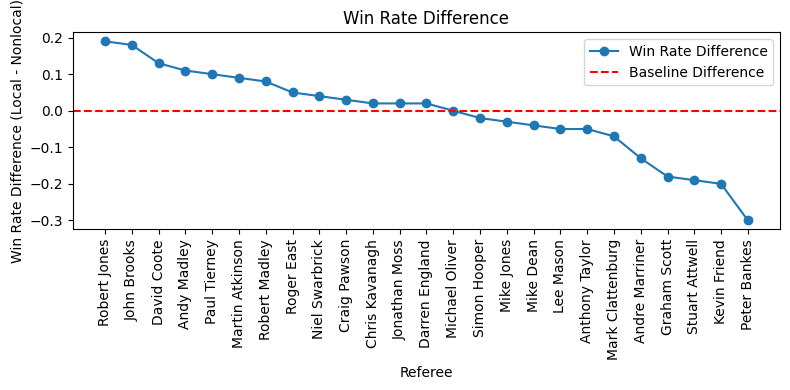

In [10]:
# To better visualize the win rate difference when referee officating local teams and nonlocal teams
# Here I write the code to visualize the output using a chart and set asceding equals to False
combined_df['Win_Rate_Diff'] = combined_df['Win Rate_local'] - combined_df['Win Rate_nonlocal']

combined_df = combined_df.sort_values(by='Win_Rate_Diff', ascending=False)

plt.figure(figsize=(8,4))
plt.plot(combined_df['Referee'], combined_df['Win_Rate_Diff'], marker='o', linestyle='-', label='Win Rate Difference')

plt.axhline(0, color='red', linestyle='--', label='Baseline Difference')
plt.xlabel('Referee')
plt.ylabel('Win Rate Difference (Local - Nonlocal)')
plt.title('Win Rate Difference')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

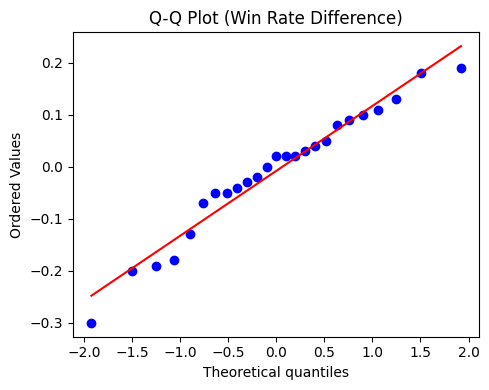

In [11]:
# There are multiple ways to conduct the statistical testing such as t-test and Mann-Whitney
# and need to first figure out whether the data I try to analyze is normally distributed
# Here I draw a Q-Q plot to check if the win rate difference data of each referee is normally distributed
from scipy import stats

data = combined_df['Win_Rate_Diff'].dropna()
plt.figure(figsize=(5,4))

stats.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot (Win Rate Difference)")
plt.tight_layout()
plt.show()

In [12]:
from scipy.stats import shapiro

stat, p = shapiro(data)

print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p}")

Shapiro-Wilk Test Statistic: 0.9630270230870899
P-value: 0.47799655089381693


In [13]:
# After confirming the data distribution, I choose to use one sample t-test
# My original hypothesis is that referee doesn't make bias decision
# Since the p-value = 0.745 which is greater than 0.05, which support the original hypothesis
# Conclusion: Referee hometown doesn’t seem to affect match outcomes in terms of win rate.
t_stat, p_val = ttest_1samp(combined_df['Win_Rate_Diff'].dropna(), 0)
print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

t-statistic = -0.329, p-value = 0.745


In [14]:
# To further confirm this conclusion, I use wilcoxon method to validate
# and the outcome of p-value = 0.9203 still support the original hypothesis
from scipy.stats import wilcoxon

win_rate_diff = combined_df['Win_Rate_Diff'].dropna()
stat, p = wilcoxon(win_rate_diff)

print(f"Wilcoxon Test: statistic = {stat:.4f}, p-value = {p:.4f}")

Wilcoxon Test: statistic = 146.5000, p-value = 0.9203


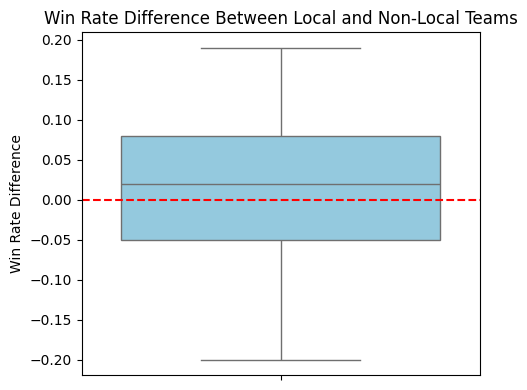

In [15]:
# This chart shows the win rate difference between local and non-local teams.
# The differences are spread on both sides of zero — some referees favor local teams, others don’t.
plt.figure(figsize=(5,4))
sns.boxplot(y=combined_df['Win_Rate_Diff'], color='skyblue', showfliers=False)
plt.axhline(0, color='red', linestyle='--')
plt.title("Win Rate Difference Between Local and Non-Local Teams")
plt.ylabel("Win Rate Difference")
plt.tight_layout()
plt.show()

In [16]:
# After evaluting the aspect of win rate difference, here I try to alayze the referee bias in terms of
# cards(red and yellow), fouls, as well as the ratio (cards/fouls), that is number of fouls per card
# The output is the data of referee in each local match
# The criteria is:
# 1) diff_cards < 0 indicates local team receives less cards in a single match,
# 2) diff_fls < 0 indicates less fouls will be confirmed by referee (or just have less fouls)
# 3) diff_ratio > 0 indicates number of fouls per card of local team is greater than nonlocal team, referee is in favor of local team
card_df = df.copy()

match_stats = []

for (home_idx, away_idx) in matched_pairs:
    home_record = card_df.loc[home_idx]
    away_record = card_df.loc[away_idx]

    referee = home_record['Referee']
    referee_hometown = home_record['Referee Broad Region']

    local_record = None
    nonlocal_record = None
    if (home_record['Team Region'] == referee_hometown) and (away_record['Team Region'] != referee_hometown):
        local_record = home_record
        nonlocal_record = away_record
    elif (away_record['Team Region'] == referee_hometown) and (home_record['Team Region'] != referee_hometown):
        local_record = away_record
        nonlocal_record = home_record
    else:
        continue

    local_crds = local_record['CrdY'] + local_record['2CrdY'] + local_record['CrdR']
    nonlocal_crds = nonlocal_record['CrdY'] + nonlocal_record['2CrdY'] + nonlocal_record['CrdR']

    local_fls = local_record['Fls (fouls committed)']
    nonlocal_fls = nonlocal_record['Fls (fouls committed)']

    # local_ratio = round(local_crds / local_fls, 2) if local_fls else np.nan
    # nonlocal_ratio = round(nonlocal_crds / nonlocal_fls, 2) if nonlocal_fls else np.nan

    local_ratio = round(local_fls / local_crds, 2) if local_crds else np.nan
    nonlocal_ratio = round(nonlocal_fls / nonlocal_crds, 2) if nonlocal_crds else np.nan

    match_stats.append({
        'Referee': referee,
        'Diff_Cards': local_crds - nonlocal_crds,
        'Diff_Fouls': local_fls - nonlocal_fls,
        'Diff_Ratio': local_ratio - nonlocal_ratio
    })

match_stats_df = pd.DataFrame(match_stats)
print(match_stats_df.head())

          Referee  Diff_Cards  Diff_Fouls  Diff_Ratio
0  Michael Oliver          -2           0        3.00
1  Anthony Taylor          -3         -12       -1.18
2    Robert Jones           4          -2       -4.00
3    Craig Pawson          -1          -1         NaN
4    Simon Hooper           0           0        0.00


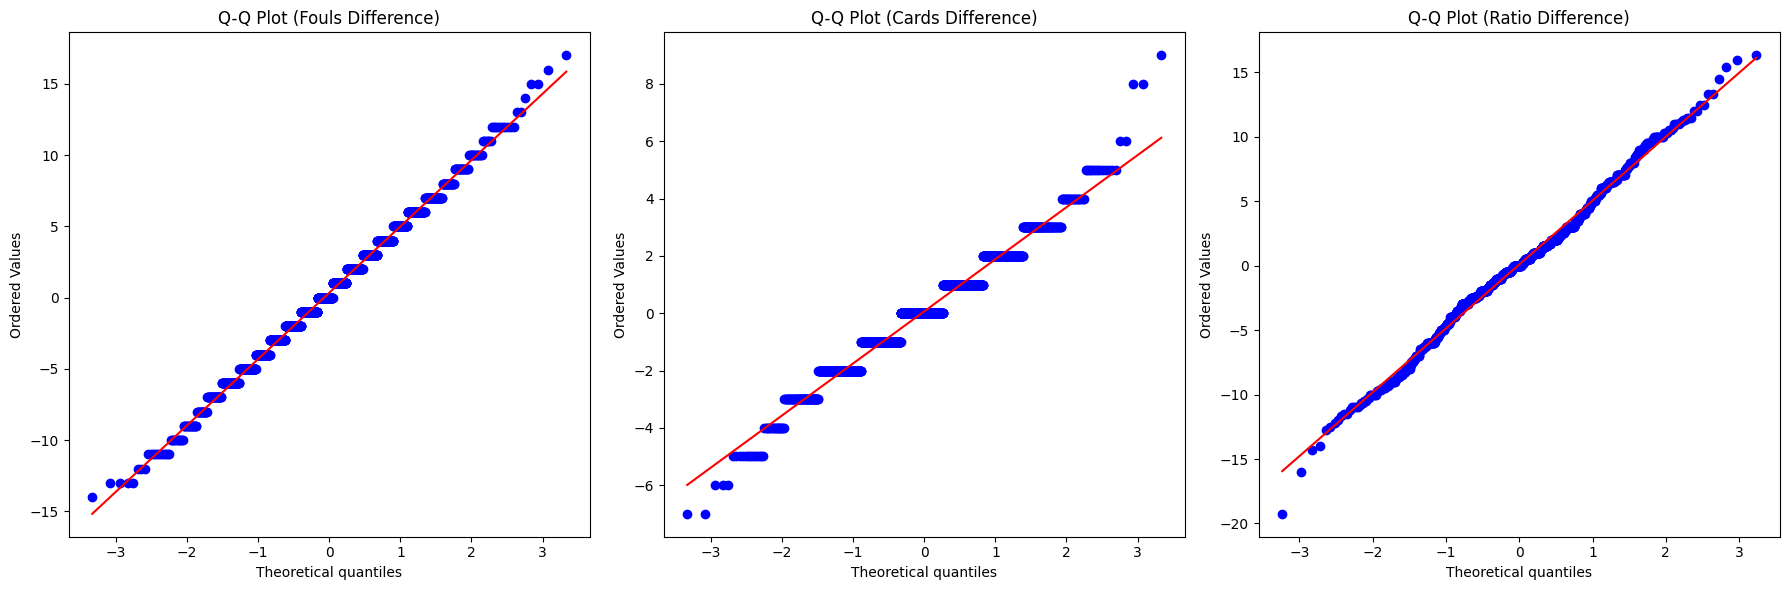

In [17]:
# Here is the Q-Q plot to figure out which method to use to explore if the referee bias exists
# From the plot, the data is normally distributed and I decide to use one sample t-tets
fls = match_stats_df['Diff_Fouls'].dropna()
crds = match_stats_df['Diff_Cards'].dropna()
ratio = match_stats_df['Diff_Ratio'].dropna()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

stats.probplot(fls, dist="norm", plot=axs[0])
axs[0].set_title("Q-Q Plot (Fouls Difference)")

stats.probplot(crds, dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Plot (Cards Difference)")

stats.probplot(ratio, dist="norm", plot=axs[2])
axs[2].set_title("Q-Q Plot (Ratio Difference)")

plt.tight_layout()
plt.show()

In [18]:
# Shapiro-Wilk tests
shapiro_fls = shapiro(fls)
shapiro_crds = shapiro(crds)
shapiro_ratio = shapiro(ratio)

print("Shapiro-Wilk Test (Fouls Difference):", shapiro_fls.pvalue)
print("Shapiro-Wilk Test (Cards Difference):", shapiro_crds.pvalue)
print("Shapiro-Wilk Test (Ratio Difference):", shapiro_ratio.pvalue)

Shapiro-Wilk Test (Fouls Difference): 7.817606432322678e-05
Shapiro-Wilk Test (Cards Difference): 3.0746683128652215e-18
Shapiro-Wilk Test (Ratio Difference): 0.00029726719986667555


In [19]:
# Since the plots show that the data are normally distributed, t-test is applied and the results indicate:
# 1) there is significant difference between difference in fouls and t-statistic = 2.9 shows that local teams will have more fouls than nonlocal team
# 2) both diff_cards and diff_ratio are not statistically significant
# Conclusion: these results indicate that behavioral indicators like fouls and cards do not consistently support the existence of hometown bias
print("t-tests:")
t_stat_f, p_val_f = ttest_1samp(match_stats_df['Diff_Fouls'].dropna(), 0)
print(f"Diff_Fouls: t-statistic = {t_stat_f:.3f}, p-value = {p_val_f:.3f}")

t_stat_c, p_val_c = ttest_1samp(match_stats_df['Diff_Cards'].dropna(), 0)
print(f"Diff_Cards: t-statistic = {t_stat_c:.3f}, p-value = {p_val_c:.3f}")

t_stat_r, p_val_r = ttest_1samp(match_stats_df['Diff_Ratio'].dropna(), 0)
print(f"Diff_Ratio: t-statistic = {t_stat_r:.3f}, p-value = {p_val_r:.3f}")

t-tests:
Diff_Fouls: t-statistic = 2.940, p-value = 0.003
Diff_Cards: t-statistic = 1.404, p-value = 0.161
Diff_Ratio: t-statistic = 0.658, p-value = 0.511


In [20]:
# Like the analysis of win rate, I also use wilcoxon to further confirm the conlusion
# There is no bias witnessed on terms of cards and fouls
from scipy.stats import wilcoxon

w_stat_fls, p_w_fls = wilcoxon(fls)
w_stat_crds, p_w_crds = wilcoxon(crds)
w_stat_ratio, p_w_ratio = wilcoxon(ratio)

print("Wilcoxon test:")
print(f"Fouls Diff: stat = {w_stat_fls:.3f}, p = {p_w_fls:.3f}")
print(f"Cards Diff: stat = {w_stat_crds:.3f}, p = {p_w_crds:.3f}")
print(f"Ratio Diff: stat = {w_stat_ratio:.3f}, p = {p_w_ratio:.3f}")

Wilcoxon test:
Fouls Diff: stat = 498694.500, p = 0.004
Cards Diff: stat = 365160.000, p = 0.166
Ratio Diff: stat = 291825.500, p = 0.529


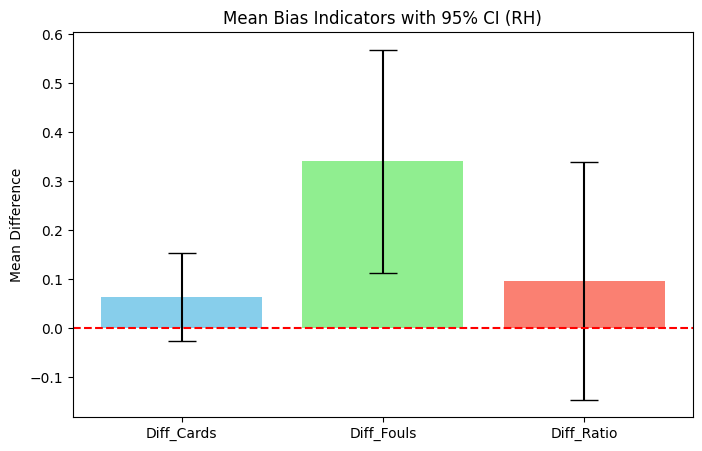

In [22]:
features = ['Diff_Cards', 'Diff_Fouls', 'Diff_Ratio']
means = [match_stats_df[feat].mean() for feat in features]
stds = [match_stats_df[feat].std() for feat in features]
n = len(match_stats_df)

cis = [1.96 * std / np.sqrt(n) for std in stds]

plt.figure(figsize=(8, 5))
plt.bar(features, means, yerr=cis, capsize=10, color=['skyblue', 'lightgreen', 'salmon'])
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Mean Difference')
plt.title('Mean Bias Indicators with 95% CI (RH)')
plt.show()

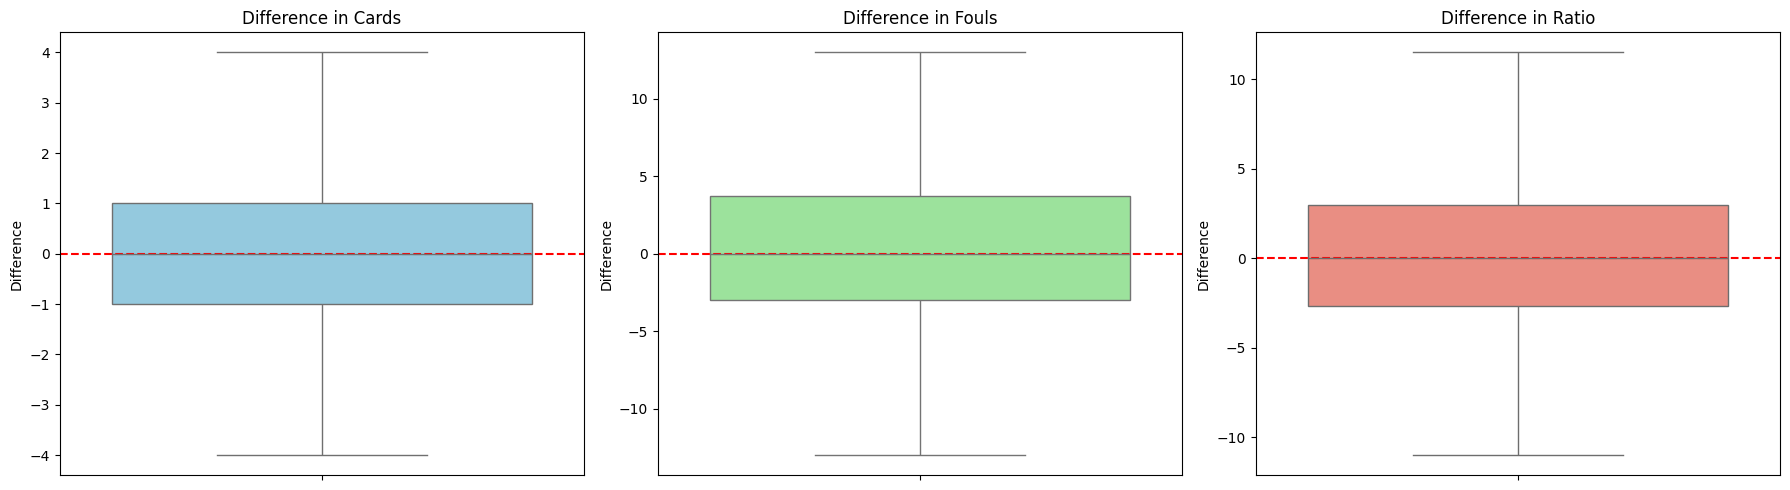

In [55]:
features = ['Diff_Cards', 'Diff_Fouls', 'Diff_Ratio']
titles = ['Difference in Cards', 'Difference in Fouls', 'Difference in Ratio']
colors = ['skyblue', 'lightgreen', 'salmon']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(features):
    sns.boxplot(
        y=match_stats_df[feature],
        ax=axes[i],
        color=colors[i],
        showfliers=False
    )
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('Difference')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

In [56]:
# After analyzing fouls, cards as well as the corresponding ratio, I want to have a further exploration of extra time given by referee
# Here I calculate regular goal difference so that the regular time outcome can be easily determined (Leading, Drawing and Trailing)
# And I also construct a varibale to determine whether the outcome is changed after the extra time
extra_time_df = df.copy()

extra_time_stats = []

for (home_idx, away_idx) in matched_pairs:
  home_record = extra_time_df.loc[home_idx]
  away_record = extra_time_df.loc[away_idx]

  referee = home_record['Referee']
  referee_hometown = home_record['Referee Broad Region']

  local_record = None
  nonlocal_record = None

  if (home_record['Team Region'] == referee_hometown) and (away_record['Team Region'] != referee_hometown):
    local_record = home_record
    nonlocal_record = away_record
  elif (away_record['Team Region'] == referee_hometown) and (home_record['Team Region'] != referee_hometown):
    local_record = away_record
    nonlocal_record = home_record
  else:
    continue

  if local_record.equals(home_record):
    local_extra_goal = home_record['Second Extra Team Goal']
    nonlocal_extra_goal = home_record['Second Extra Opponent Goal']
  else:
    local_extra_goal = away_record['Second Extra Team Goal']
    nonlocal_extra_goal = away_record['Second Extra Opponent Goal']

  diff_extra_goals = local_extra_goal - nonlocal_extra_goal
  extra_time = home_record['Second Extra Time']

  local_regular_goal = local_record['GF (goals for)'] - local_extra_goal
  nonlocal_regular_goal = nonlocal_record['GF (goals for)'] - nonlocal_extra_goal
  regular_goal_diff = local_regular_goal - nonlocal_regular_goal

  if regular_goal_diff > 0:
    outcome = "Leading"
  elif regular_goal_diff == 0:
    outcome = "Drawing"
  else:
    outcome = "Trailing"

  final_result = local_record['Result']

  if outcome != "Leading" and final_result == "W":
    outcome_change = True
  elif outcome == "Leading" and final_result != "W":
    outcome_change = True
  else:
    outcome_change = False

  extra_time_stats.append({
      'Referee': referee,
      'Match': (home_record['Team'], away_record['Team']),
      'Regular_Time_Outcome': outcome,
      'Final_Result': final_result,
      'Outcome_Changed': outcome_change,
      'Regular_Goal_Difference': regular_goal_diff,
      'Extra_Time': extra_time,
      'Local_Extra_Goal': local_extra_goal,
      'Nonlocal_Extra_Goal': nonlocal_extra_goal,
      'Extra_Goal_Difference': diff_extra_goals,
  })

extra_time_df = pd.DataFrame(extra_time_stats)
print(extra_time_df.head())

          Referee                                      Match  \
0  Michael Oliver                  (Manchester City, Fulham)   
1  Anthony Taylor       (Manchester City, Nottingham Forest)   
2    Robert Jones  (Manchester City, Brighton & Hove Albion)   
3    Craig Pawson             (Manchester City, Bournemouth)   
4    Simon Hooper       (Manchester City, Tottenham Hotspur)   

  Regular_Time_Outcome Final_Result  Outcome_Changed  Regular_Goal_Difference  \
0              Leading            W            False                      3.0   
1              Leading            W            False                      2.0   
2              Leading            W            False                      1.0   
3              Leading            W            False                      5.0   
4              Drawing            D            False                      0.0   

   Extra_Time  Local_Extra_Goal  Nonlocal_Extra_Goal  Extra_Goal_Difference  
0           7                 1                  0

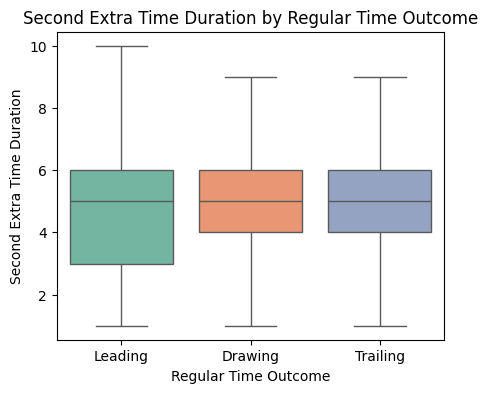

Group means of Extra Time Duration:
Regular_Time_Outcome
Drawing     5.09
Leading     4.76
Trailing    5.05
Name: Extra_Time, dtype: float64


In [57]:
# This plot shows the extra time range of different regular time outcome and I calculate the mean extra time of three different regular time outcome
# From the plot we can see that although the range seems to be the same for three different outcome, the lower bound of 'Leading'
# is considerably smaller than 'Drawing' and 'Trailing'
plt.figure(figsize=(5,4))
sns.boxplot(x='Regular_Time_Outcome', y='Extra_Time', data=extra_time_df, palette="Set2", showfliers=False)

plt.title("Second Extra Time Duration by Regular Time Outcome")
plt.xlabel("Regular Time Outcome")
plt.ylabel("Second Extra Time Duration")
plt.show()

group_means = extra_time_df.groupby('Regular_Time_Outcome')['Extra_Time'].mean().round(2)
print("Group means of Extra Time Duration:")
print(group_means)

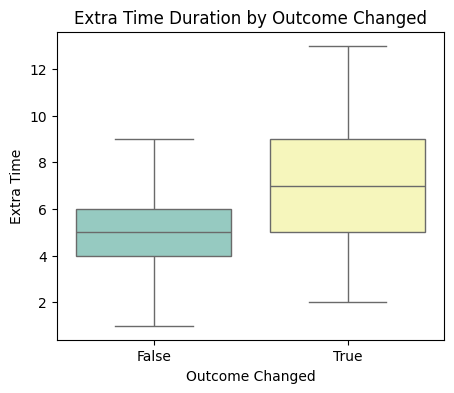

In [58]:
# This plot indicate that if the outcome changed in the extra time, the extra time is normally longer than those matches that outcome didn't change
# Also, the median of outcome changed equals to True is larger
plt.figure(figsize=(5,4))
sns.boxplot(x='Outcome_Changed', y='Extra_Time', data=extra_time_df, palette="Set3", showfliers=False)
plt.title("Extra Time Duration by Outcome Changed")
plt.xlabel("Outcome Changed")
plt.ylabel("Extra Time")
plt.show()

In [62]:
# Here I use Kruskal-Wallis since I want to compare whether the three regular outcomes' extra time have significant difference
# and there are three individual samples and it doesn't require the data to be normally distributed
# The result of p-value = 0.017 that is smaller than 0.05 implies that there is at least one pair extra time data that has significant difference
from scipy.stats import kruskal

group_leading = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Leading']['Extra_Time'].dropna()
group_drawing = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Drawing']['Extra_Time'].dropna()
group_trailing = extra_time_df[extra_time_df['Regular_Time_Outcome'] == 'Trailing']['Extra_Time'].dropna()

stat_kruskal, p_kruskal = kruskal(group_leading, group_drawing, group_trailing)

print(f"Kruskal-Wallis test: stat = {stat_kruskal:.3f}, p = {p_kruskal:.3f}")

Kruskal-Wallis test: stat = 8.122, p = 0.017


In [63]:
!pip install scikit_posthocs

In [68]:
# Then I want to figure out which pair is significantly different, therefore, I use dunn's testn here
# The result shows that Leading & Drawing is statistically different and Leading & Trailing is as well statistically different
# Combined with the boxplot above, we can see that matches where the team is leading in regular time tend to receive less extra time,
# compared to when the match is drawing or trailing.
# This suggests that referees may add less extra time when the result is already favorable for the team which can be seen as a potential subtle form of bias.
from scikit_posthocs import posthoc_dunn

p_dunn = (posthoc_dunn([group_leading, group_drawing, group_trailing], p_adjust="holm")).round(2)
p_dunn.index = ['Leading', 'Drawing', 'Trailing']
p_dunn.columns = ['Leading', 'Drawing', 'Trailing']

print("Dunn's test p-values:")
print(p_dunn)

Dunn's test p-values:
          Leading  Drawing  Trailing
Leading      1.00     0.04      0.04
Drawing      0.04     1.00      0.72
Trailing     0.04     0.72      1.00


Optimization terminated successfully.
         Current function value: 0.119582
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:     is_Outcome_Changed   No. Observations:                 1614
Model:                          Logit   Df Residuals:                     1608
Method:                           MLE   Df Model:                            5
Date:                Wed, 07 May 2025   Pseudo R-squ.:                  0.2375
Time:                        20:57:06   Log-Likelihood:                -193.01
converged:                       True   LL-Null:                       -253.14
Covariance Type:            nonrobust   LLR p-value:                 2.766e-24
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -4.6486      0.404

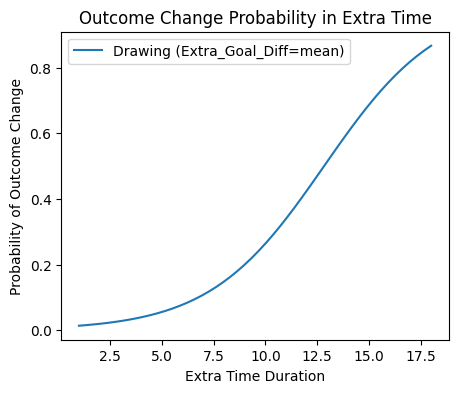

In [69]:
# Here I try to use logistic regression to analyze and the conclusions are:
# 1) the longer extra time or more extra goals, the higher probability of outcome change and
# 2) if the regular outcome is drawing, the probability of outcome change is also higher
extra_time_df['is_Outcome_Changed'] = extra_time_df['Outcome_Changed'].astype(int)

model_outcome = smf.logit("is_Outcome_Changed ~ Extra_Time + Extra_Goal_Difference + C(Regular_Time_Outcome) + Extra_Time:Extra_Goal_Difference", data=extra_time_df).fit()
print(model_outcome.summary())

time_range = np.linspace(extra_time_df['Extra_Time'].min(), extra_time_df['Extra_Time'].max(), 50)
df_pred = pd.DataFrame({
    'Extra_Time': time_range,
    'Extra_Goal_Difference': extra_time_df['Extra_Goal_Difference'].mean(),
    'Regular_Time_Outcome': 'Drawing'
})
df_pred['pred_prob'] = model_outcome.predict(df_pred)

plt.figure(figsize=(5,4))
plt.plot(df_pred['Extra_Time'], df_pred['pred_prob'], label="Drawing (Extra_Goal_Diff=mean)")
plt.xlabel("Extra Time Duration")
plt.ylabel("Probability of Outcome Change")
plt.title("Outcome Change Probability in Extra Time")
plt.legend()
plt.show()

In [70]:
# After analyzing the referee Behavioral indicators, I try to analyze the match indicator such as expected goals
# The preprocessing method here eliminate data that have empty xG before analysis
xg_df = df.copy()

xg_df = xg_df.dropna(subset=['xG (expected goals)'])

clean_matched_pairs = []

for (home_idx, away_idx) in matched_pairs:
    if home_idx in xg_df.index and away_idx in xg_df.index:
        home_xg = xg_df.loc[home_idx]['xG (expected goals)']
        away_xg = xg_df.loc[away_idx]['xG (expected goals)']
        if pd.notnull(home_xg) and pd.notnull(away_xg):
            clean_matched_pairs.append((home_idx, away_idx))

print("Number of matched pairs after cleaning:", len(clean_matched_pairs))

Number of matched pairs after cleaning: 2660


In [73]:
# I construct a data frame including xG difference and is_win of a single match
xg_stats = []

for (home_idx, away_idx) in clean_matched_pairs:
  home_record = xg_df.loc[home_idx]
  away_record = xg_df.loc[away_idx]

  referee = home_record['Referee']
  referee_hometown = home_record['Referee Broad Region']

  local_record = None
  nonlocal_record = None
  if (home_record['Team Region'] == referee_hometown) and (away_record['Team Region'] != referee_hometown):
    local_record = home_record
    nonlocal_record = away_record
  elif (away_record['Team Region'] == referee_hometown) and (home_record['Team Region'] != referee_hometown):
    local_record = away_record
    nonlocal_record = home_record
  else:
    continue

  local_xg = local_record['xG (expected goals)']
  nonlocal_xg = nonlocal_record['xG (expected goals)']
  diff_xg = local_xg - nonlocal_xg

  xg_stats.append({
      'Referee': referee,
      'Local_xG': local_xg,
      'Nonlocal_xG': nonlocal_xg,
      'Diff_xG': diff_xg,
      'is_win': local_record['is_win']
  })

xg_stats_df = pd.DataFrame(xg_stats)
print(xg_stats_df.head())

          Referee  Local_xG  Nonlocal_xG  Diff_xG  is_win
0  Michael Oliver       2.2          1.4      0.8       1
1  Anthony Taylor       1.3          1.0      0.3       1
2    Robert Jones       0.8          0.8      0.0       1
3    Craig Pawson       1.9          0.9      1.0       1
4    Simon Hooper       0.5          2.6     -2.1       0


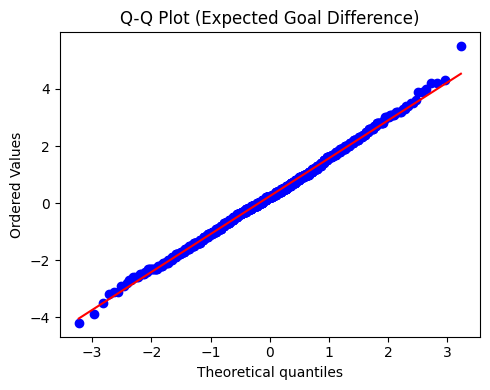

In [74]:
# First use Q-Q plot to figure out whether data is normally ditributed
xg = xg_stats_df['Diff_xG'].dropna()
plt.figure(figsize=(5,4))

stats.probplot(xg, dist="norm", plot=plt)
plt.title("Q-Q Plot (Expected Goal Difference)")
plt.tight_layout()
plt.show()

In [75]:
stat, p = shapiro(xg)

print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p}")

Shapiro-Wilk Test Statistic: 0.9978860721966547
P-value: 0.1711498062334218


In [76]:
# The p-value here shows that there might be significant difference
t_stat, p_val = ttest_1samp(xg_stats_df['Diff_xG'].dropna(), 0)
print(f"t-test for Diff_xG: t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

t-test for Diff_xG: t-statistic = 6.109, p-value = 0.000


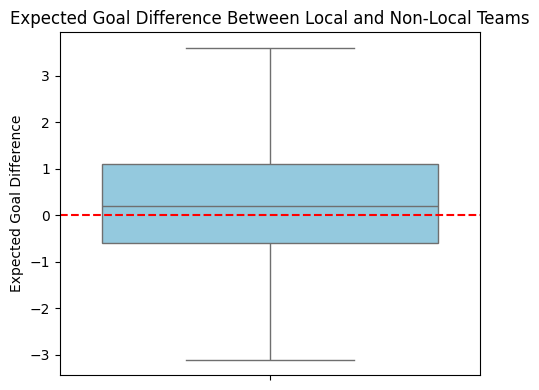

In [77]:
plt.figure(figsize=(5,4))
sns.boxplot(y=xg_stats_df['Diff_xG'], color='skyblue', showfliers=False)
plt.axhline(0, color='red', linestyle='--')
plt.title("Expected Goal Difference Between Local and Non-Local Teams")
plt.ylabel("Expected Goal Difference")
plt.tight_layout()
plt.show()

In [78]:
# The simple logistic regression shows a very strong and significant effect
# For every single unit of xG difference, the probability of winning increases by nearly 20%
xg_win = smf.logit("is_win ~ Diff_xG", data=xg_stats_df).fit()
print(xg_win.summary())

margeff = xg_win.get_margeff()
print(margeff.summary())

Optimization terminated successfully.
         Current function value: 0.532458
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 is_win   No. Observations:                 1109
Model:                          Logit   Df Residuals:                     1107
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 May 2025   Pseudo R-squ.:                  0.2297
Time:                        20:57:59   Log-Likelihood:                -590.50
converged:                       True   LL-Null:                       -766.55
Covariance Type:            nonrobust   LLR p-value:                 1.469e-78
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4291      0.074     -5.786      0.000      -0.574      -0.284
Diff_xG        1.1049      0.

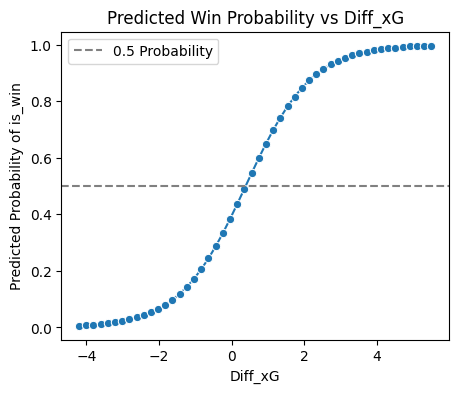

In [ ]:
diff_xg_range = np.linspace(xg_stats_df['Diff_xG'].min(), xg_stats_df['Diff_xG'].max())

df_pred = pd.DataFrame({'Diff_xG': diff_xg_range})

df_pred['pred_prob'] = xg_win.predict(df_pred)

plt.figure(figsize=(5,4))
sns.lineplot(x='Diff_xG', y='pred_prob', data=df_pred, marker="o")
plt.xlabel("Diff_xG")
plt.ylabel("Predicted Probability of is_win")
plt.title("Predicted Win Probability vs Diff_xG")
plt.axhline(0.5, color='gray', linestyle='--', label="0.5 Probability")
plt.legend()
plt.show()

In [ ]:
ref_xg = (xg_stats_df.groupby('Referee')['Diff_xG'].agg(['mean', 'std', 'count']).round(2))
ref_xg = ref_xg.rename(columns={'mean': 'Avg_Diff_xG', 'std': 'SD_Diff_xG', 'count': 'matches'})
ref_xg = ref_xg[ref_xg['matches'] > 5]

print("Per-Referee Average Diff_xG (Only Referees with > 5 Matches):")
print(ref_xg.sort_values(by='Avg_Diff_xG', ascending=False).reset_index())

Per-Referee Average Diff_xG (Only Referees with > 5 Matches):
              Referee  Avg_Diff_xG  SD_Diff_xG  matches
0      Niel Swarbrick         0.93        1.41       15
1       Jonathan Moss         0.85        1.16       63
2          Mike Jones         0.83        1.14        6
3        Robert Jones         0.76        1.19       26
4      Michael Oliver         0.49        1.40       88
5           Mike Dean         0.45        1.46       66
6     Martin Atkinson         0.34        1.16       70
7        Paul Tierney         0.32        1.33       88
8        Craig Pawson         0.29        1.37       73
9      Darren England         0.26        1.48       31
10     Anthony Taylor         0.24        1.33       96
11         Roger East         0.23        1.35       15
12     Chris Kavanagh         0.23        1.37       67
13     Andre Marriner         0.22        1.49       21
14       Simon Hooper         0.14        1.30       56
15        John Brooks         0.13        

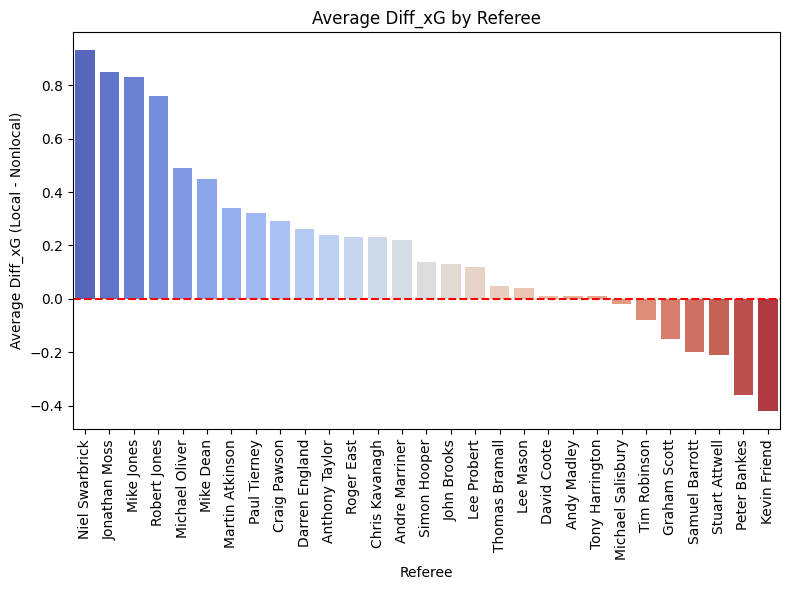

In [ ]:
# Here I output a plot to find out which referee is most likely to make bias decisions under the conditio of expected goals
# The result is Niel Swarbrick is that referee
plt.figure(figsize=(8,6))
sns.barplot(x='Referee', y='Avg_Diff_xG', data=ref_xg.sort_values(by='Avg_Diff_xG', ascending=False), palette="coolwarm")
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel("Referee")
plt.ylabel("Average Diff_xG (Local - Nonlocal)")
plt.title("Average Diff_xG by Referee")
plt.tight_layout()
plt.show()